In [1]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
from scipy.stats import pearsonr

from utils import *

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

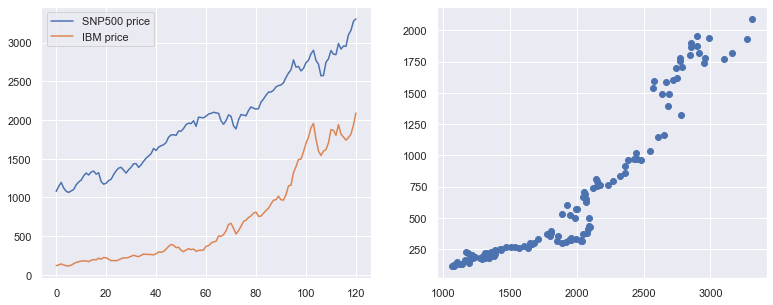

In [2]:
amzn_data = pd.read_csv('../Data/AMZN.csv',parse_dates =['Date'])
snp_data = pd.read_csv('../Data/GSPC.csv',parse_dates=['Date'])

snp_data['Price'] = (snp_data.High + snp_data.Low)*0.5
amzn_data['Price'] = (amzn_data.High + amzn_data.Low)*0.5

fig, ax = plt.subplots(1,2,figsize=(13,5))

snp_data['Price'].plot(label = 'SNP500 price',ax=ax[0])
amzn_data['Price'].plot(label = 'IBM price',ax=ax[0])

X,y = snp_data['Price'].values,amzn_data.Price.values

ax[0].legend()

plt.scatter(snp_data['Price'],amzn_data['Price']);

Завдання: Побудова нелінійної регресії

* (A) Використовуючи комп'ютерне програмне забезпечення для виконання регресійних
розрахунків
𝑥 = 𝑟𝑚, 𝑦 = 𝑟𝑝
оцініть за допомогою нелінійних регресії (1-7) параметри $\alpha$ і $\beta$ для компанії.
* (B) Зробіть порівняльну характеристику для всіх моделей;
Модель | $R^2  | r |  F$
* (C) Оберіть найкращу з моделей і для неї проведіть повний статистичний аналіз.
* (D) Побудувати довірчий діапазон для регресійних значень 𝑦̂ (з рівнем довіри 95%);
* (E) Зробіть прогноз на наступний місяць, якщо ринок підніметься на 20% від попереднього
місяця, та побудуйте довірчий інтервал.
* (F) Коеф. еластичності

Визначимо регресійні функції:

In [3]:
def exponential_1(x,alpha,beta):
    return alpha * np.power(beta,x)

def exponential_2(x,alpha,beta):
    return alpha * np.exp(beta*x)

def exponential_3(x,alpha,beta):
    return np.exp(alpha+beta*x)

def exponential_4(x,alpha,beta):
    return np.power(10,alpha+beta*x)

def multiplicative(x,alpha,beta):
    return alpha * x**beta

def inverse(x,alpha,beta):
    return alpha+beta/x

Загальний метод найменших квадратів для оцінки $\alpha, \beta$, обчислення $r, R^2, F$

In [4]:
class OLS(BaseEstimator):
    def __init__(self):
        super(OLS,self).__init__()
        
    def fit(self,X,y=None):
        self.r_,_ = pearsonr(X,y)
        
        self.beta_ = self.r_*(y.std())/X.std()
        self.alpha_ = y.mean() - X.mean()*self.beta_
        return self
        
    def predict(self,X,y=None):
        try:
            getattr(self, "beta_")
            getattr(self, "alpha_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        
        return self.alpha_ + X*self.beta_
    
    def coef_(self):
        return self.alpha_,self.beta_
    
    @staticmethod
    def r_squared(y,y_pred):
        return np.var(y_pred)/np.var(y)
  
    @staticmethod
    def f_statistic(y,y_pred):
        n=y.shape[0]
        R_2 = r2_score(y,y_pred)
        return (R_2*(n-2))/((1-R_2))
    
    @staticmethod
    def su_squared(y,y_pred):
        n,e = y.shape[0],y-y_pred 
        return n*np.var(e)/(n-2)

    @staticmethod
    def sp_y_pred(x,y,y_pred):
        mean, var,n = x.mean(), x.var(),x.shape[0]
        su_2 = OLS.su_squared(y,y_pred)

        b = n+1+(x-mean)**2/var
        return np.sqrt(su_2*b/n)

    @staticmethod
    def calculate_sp(X,y,y_pred):#standard error    
        sp_dict = {}
        
        n,mean,var = y.shape[0],X.mean(),np.var(X)
        
        su_2 = OLS.su_squared(y,y_pred)
        sp_dict['su_squared']=su_2
        
        sp_dict['slope'] = np.sqrt(su_2/(n*var))
        sp_dict['intercept'] = np.sqrt(su_2*(1+mean**2/var)/n)
        sp_dict['y_pred'] = OLS.sp_y_pred(X,y,y_pred)
    
        return sp_dict
    

def calculate_conf_int(val,sp_dict,key,t_crit):
    return val - sp_dict[key]*t_crit, val + sp_dict[key]*t_crit

    
data_dicts = []

* Експоненційна регресія:
1. $y = \alpha*\beta^x \Leftrightarrow ln(y)=ln(\alpha) + ln(\beta)*x \Leftrightarrow y=exp(ln(\alpha) + ln(\beta)*x $

model coefficients: 
	alpha=30.4991, beta=1.0014
model characteristics: 
	r=0.9463,R^2=0.8869,F=932.7917
	Elasticity=0.0014


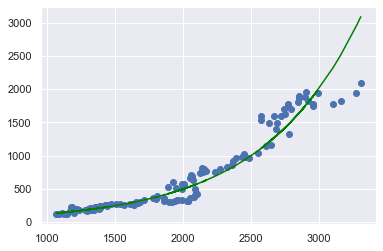

In [5]:
ols_model = OLS().fit(X,np.log(y))
ln_alpha, ln_beta = ols_model.coef_()
alpha,beta = np.exp(ln_alpha),np.exp(ln_beta)

y_hat = exponential_1(X,np.exp(ln_alpha),np.exp(ln_beta))

plt.scatter(X,y)
plt.plot(X,y_hat,c='green');
r,r_sq,f_val = pearsonr(y,y_hat)[0],r2_score(y,y_hat),OLS.f_statistic(y,y_hat)
elasticity = ln_beta * 1
data_dicts.append({'Модель':'$\alpha* \beta^x$','$r$':r,'$R^2$':r_sq,'$F_{val}$':f_val,'Elasticity':elasticity})
print(f'model coefficients: \n\talpha={alpha:.4f}, beta={beta:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}\n\tElasticity={elasticity:.4f}')

2. $y = \alpha*e^{\beta x} \Leftrightarrow ln(y)= ln(\alpha) + b1* x \Leftrightarrow y = exp (ln\alpha + b1*x)  $

model coefficients: 
	alpha=30.4991, beta=0.0014
model characteristics: 
	r=0.9463,R^2=0.8869,F=932.7917
	Elasticity=0.0014


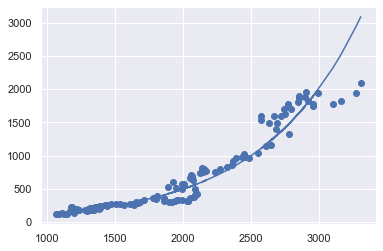

In [6]:
ols_model = OLS().fit(X,np.log(y))
b0,b1 = ols_model.coef_()
alpha,beta = np.exp(b0),b1
y_hat = exponential_2(X,alpha,beta)

plt.scatter(X,y)
plt.plot(X,y_hat)
r,r_sq,f_val = pearsonr(y,y_hat)[0],r2_score(y,y_hat),OLS.f_statistic(y,y_hat)
elasticity = b1 * 1
data_dicts.append({'Модель':'$\alpha* \beta^x$','$r$':r,'$R^2$':r_sq,'$F_{val}$':f_val,'Elasticity':elasticity})
print(f'model coefficients: \n\talpha={alpha:.4f}, beta={beta:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}\n\tElasticity={elasticity:.4f}')

3. $y = e^{b_0 +b_1*x} \Leftrightarrow ln(y)=b_0+b_1*x \Leftrightarrow y=exp(b_0+b_1*x)$

model coefficients: 
	alpha=3.4177, beta=0.0014
model characteristics: 
	r=0.9463,R^2=0.8869,F=932.7917
	Elasticity=0.0014


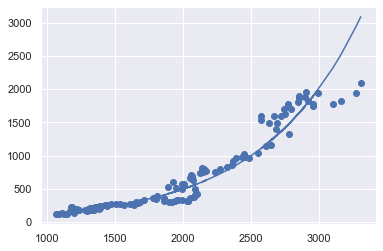

In [7]:
ols_model = OLS().fit(X,np.log(y))
b0,b1 = ols_model.coef_()
alpha,beta = b0,b1

y_hat = exponential_3(X,b0,b1)
plt.scatter(X,y)
plt.plot(X,y_hat)
r,r_sq,f_val = pearsonr(y,y_hat)[0],r2_score(y,y_hat),OLS.f_statistic(y,y_hat)
elasticity = beta * 1
data_dicts.append({'Модель':'$\alpha* \beta^x$','$r$':r,'$R^2$':r_sq,'$F_{val}$':f_val,'Elasticity':elasticity})
print(f'model coefficients: \n\talpha={alpha:.4f}, beta={beta:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}\n\tElasticity={elasticity:.4f}')

4. $y = 10^{b_0+b_1x} \Leftrightarrow log10(y) = b_0 + b_1 x \Leftrightarrow y = 10^{b_0 + b_1x}$

model coefficients: 
	alpha=3.4177, beta=0.0014
model characteristics: 
	r=0.9463,R^2=0.8869,F=932.7917
	Elasticity=0.0014


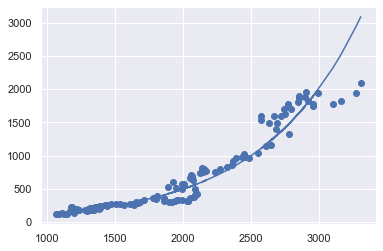

In [8]:
ols_model = OLS().fit(X,np.log10(y))
b0,b1 = ols_model.coef_()
y_hat = exponential_4(X,b0,b1)
plt.scatter(X,y)
plt.plot(X,y_hat)
r,r_sq,f_val = pearsonr(y,y_hat)[0],r2_score(y,y_hat),OLS.f_statistic(y,y_hat)
elasticity = np.log(10)* b1 * 1
data_dicts.append({'Модель':'$\alpha* \beta^x$','$r$':r,'$R^2$':r_sq,'$F_{val}$':f_val,'Elasticity':elasticity})
print(f'model coefficients: \n\talpha={alpha:.4f}, beta={beta:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}\n\tElasticity={elasticity:.4f}')

Бачимо, що усі форми експоненційної регресії дають однаковий результат, що й випливає з формул зворотніх перетворень

* Мультипликативна регресія: $ y = \alpha*x^\beta \Leftrightarrow log(y)=log(\alpha) + log(x)*\beta$

model coefficients: 
	alpha=0.000001, beta=2.6510
model characteristics: 
	r=0.9674,R^2=0.9150,F=1281.5751
	Elasticity=2.6510


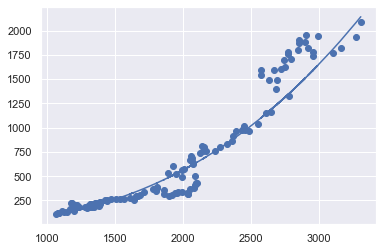

In [9]:
ols_model_multiplicative = OLS().fit(np.log(X),np.log(y))
b0,b1 = ols_model_multiplicative.coef_()
alpha,beta = np.exp(b0),b1
y_hat_multiplicative = multiplicative(X,alpha,beta)
plt.scatter(X,y)
plt.plot(X,y_hat_multiplicative)
r,r_sq,f_val = pearsonr(y,y_hat_multiplicative)[0],r2_score(y,y_hat_multiplicative),OLS.f_statistic(y,y_hat_multiplicative)
elasticity = b1 * 1
data_dicts.append({'Модель':'$\alpha* \beta^x$','$r$':r,'$R^2$':r_sq,'$F_{val}$':f_val,'Elasticity':elasticity})
print(f'model coefficients: \n\talpha={alpha:.6f}, beta={beta:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}\n\tElasticity={elasticity:.4f}')
mr_alpha,mr_beta = alpha,beta

* Зворотна: $ y = \alpha + \beta*\frac{1}{x}$

model coefficients: 
	alpha=2225.5515, beta=-2742595.2958
model characteristics: 
	r=0.8161,R^2=0.6660,F=237.2997
	Elasticity=-1.0008


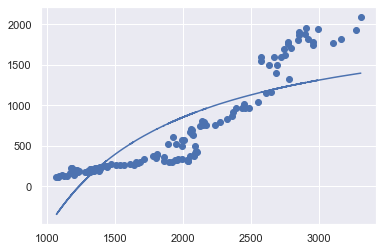

In [10]:
ols_model = OLS().fit(1/X,y)
alpha,beta = ols_model.coef_()
y_hat = inverse(X,alpha,beta)
plt.scatter(X,y)

plt.plot(X,y_hat)
r,r_sq,f_val = pearsonr(y,y_hat)[0],r2_score(y,y_hat),OLS.f_statistic(y,y_hat)

elasticity = beta /(alpha+beta)* (-1)
data_dicts.append({'Модель':'$\alpha* \beta^x$','$r$':r,'$R^2$':r_sq,'$F_{val}$':f_val,'Elasticity':elasticity})
print(f'model coefficients: \n\talpha={alpha:.4f}, beta={beta:.4f}\nmodel characteristics: \n\tr={r:.4f},R^2={r_sq:.4f},F={f_val:.4f}\n\tElasticity={elasticity:.4f}')

In [11]:
x = pd.DataFrame.from_records(data_dicts)

Порівняльна характеристика для всіх моделей:

|    | Модель                    |      $r$ |    $R^2$ |   $F_{val}$ |   Elasticity  |
|---:|:--------------------------|---------:|---------:|------------:|-----------:|
|  0 | $\alpha*\beta^x$                   | 0.946273 | 0.88686  |     932.792 |   0.001396  |
|  1 | $ \alpha *e^{\beta x}$                   | 0.946273 | 0.88686  |     932.792 |   0.001396  |
|  2 | $e^{b_0+b_1x}$      | 0.946273 | 0.88686  |     932.792 |    0.001396  |
|  3 | $10^{b_0+b_1x}$     | 0.946273 | 0.88686  |     932.792 |    0.001396  |
|  4 | $ \alpha*x^{\beta }$                   | 0.967445 | 0.915035 |    1281.58  |  2.650992  |
|  5 | $ \alpha+\beta \frac{1}{x}$                   | 0.816095 | 0.666012 |     237.3   |  -1.000812 |

Зі значень $r, R^2, F$ можемо зробити висновок, що в даному випадку мультипликативна регресія прогнозує найкраще, а зворотна регресія - найгірше. Бачимо, що для цієї моделі $R^2$ = 0.91, а F-статистика дорівнює 1281

(C) Оберіть найкращу з моделей і для неї проведіть повний статистичний аналіз.



In [12]:
print(f'Розглядаємо мультипликативну модель з параметрами alpha={mr_alpha:.8f}, beta={mr_beta:.4f}')
sp_dict = OLS().calculate_sp(X,y,y_hat_multiplicative)

Розглядаємо мультипликативну модель з параметрами alpha=0.00000100, beta=2.6510


In [13]:
import statsmodels.api as sm
x = sm.add_constant(X)
model = sm.OLS(y, x)
lin = model.fit()

Тестуємо гіпотези: 

1. $\alpha=0$<br>
$H_0: \alpha=0$<br>
$H_1: \alpha\neq0 $

In [14]:
t_value = t_val(mr_alpha,0,sp_dict['intercept'])
t_critical = stats.t.ppf(q=1-0.025,df=X.shape[0]-2)

sign,message = evaluate_hypothesis(t_value,t_critical)

print(f'T_value = {t_value:.12f} {sign} {t_critical:.4f} = T_crit. {message}')

T_value = 0.000000018678 < 1.9801 = T_crit. hypothesis must be examined further


2. $\beta=0:$<br>
$H_0: \beta=0;$<br>
$H1:\beta\neq0$

In [15]:
t_value = t_val(mr_beta,0,sp_dict['slope'])
t_critical = stats.t.ppf(q=1-0.025,df=X.shape[0]-2)

sign,message = evaluate_hypothesis(t_value,t_critical)

print(f'T_value = {t_value:.12f} {sign} {t_critical:.4f} = T_crit. {message}')

T_value = 102.523967801481 > 1.9801 = T_crit. hypothesis rejected


3. $H_0:\alpha=\beta=0;$ <br>
$H_1$:$\exists x: x\in\{\alpha,\beta\}: x\neq0$

In [16]:
f_value = F_val(y,y_hat_multiplicative)
f_critical = stats.f.ppf(q=1-0.025,dfn=1, dfd=X.shape[0]-2)

sign,msg = evaluate_hypothesis(f_value,f_critical)

print(f'F_value = {f_value:.4f} {sign} {f_critical:.4f} = F_crit. {msg}')

F_value = 276.4725 > 5.1534 = F_crit. hypothesis rejected


Бачимо, що модель є значущою

(D) Побудувати довірчий діапазон для регресійних значень 𝑦̂ (з рівнем довіри 95%);<br>

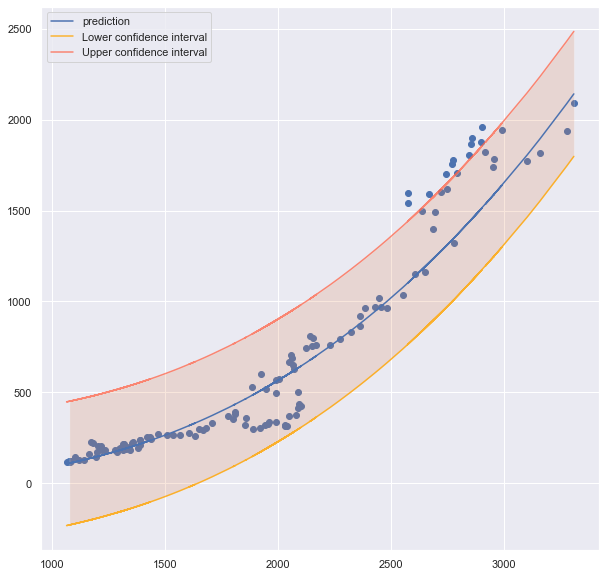

In [17]:
d = calc_delta(X,y,y_hat_multiplicative)
l,u = confidence_interval_final(X,y,y_hat_multiplicative)

plt.figure(figsize=(10,10))

plt.plot(X,y_hat_multiplicative,label='prediction')
plt.scatter(X,y)

plt.plot(X, l,alpha=0.8,color='orange',label='Lower confidence interval')
plt.plot(X, u,alpha=0.75,c='tomato',label='Upper confidence interval')

plt.fill_between(X,l,u,alpha=0.2)
plt.legend();

(E) Зробіть прогноз на наступний місяць, якщо ринок підніметься на 20% від попереднього
місяця, та побудуйте довірчий інтервал.

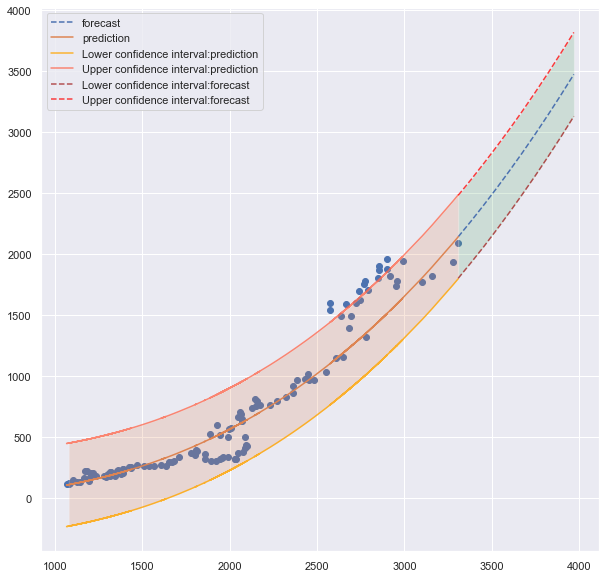

In [18]:
x_forecast = np.linspace(X[-1],1.2*X[-1],num=10)
y_hat_forecast = multiplicative(x_forecast,mr_alpha,mr_beta)
l_forecast,u_forecast = y_hat_forecast-d,y_hat_forecast+d

plt.figure(figsize=(10,10))
plt.plot(x_forecast,y_hat_forecast,'--',label='forecast')
plt.plot(X,y_hat_multiplicative,label='prediction')
plt.scatter(X,y)

plt.plot(X, l,alpha=0.8,color='orange',label='Lower confidence interval:prediction')
plt.plot(X, u,alpha=0.75,c='tomato',label='Upper confidence interval:prediction')

plt.fill_between(X,l,u,alpha=0.2)
plt.plot(x_forecast, l_forecast,'--',alpha=0.8,color='brown',label='Lower confidence interval:forecast')
plt.plot(x_forecast, u_forecast,'--',alpha=0.75,c='red',label='Upper confidence interval:forecast')

plt.fill_between(x_forecast,l_forecast,u_forecast,alpha=0.2)
plt.legend();